# Polynomial fitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's consider the example of fitting a polynomial to some measurements of $y_i(x_i)$ (ie. $y$ measured at a set of points $x_i$). An obvious way to solve the normal equations

$$\mathbf{A^T} \mathbf{d} = \mathbf{A^T}\mathbf{A}\mathbf{a}$$ 

is to calculate the inverse of $\mathbf{A^T}\mathbf{A}$ and write

$$\mathbf{a} = (\mathbf{A^T}\mathbf{A})^{-1} \mathbf{A^T} \mathbf{d}.$$

For simplicity, let's take a constant error $\sigma_i$ for each point, so the $\sigma_i$'s cancel out of the equations (it's straightforward to put them back in if you need to). 

Polynomial coeffs, Fitted coeffs, Fractional error
     0.502193      -2052.31      -4087.69
    -0.513689      -29.7869       56.9863
     0.750319        1064.3       1417.47
    -0.347159       17.1334      -50.3532
     0.922594       -273.43      -297.371
    -0.697536      -8.25762       10.8383
     -0.46542       141.117      -304.204
    -0.748258       3.03527      -5.05645
     0.555326      -63.2028      -114.812
     0.460741     -0.789882      -2.71437
     0.873278       15.1554       16.3546
     -0.49199     -0.298236     -0.393817
    -0.608905      -2.15125       2.53298
     -0.27099      -0.27356    0.00948113
      0.14188      0.202047      0.424068
    -0.120941     -0.124505     0.0294724
     0.080548     0.0860582     0.0684088
    -0.509532     -0.508955   -0.00113244
     0.590556      0.590151  -0.000684718
   -0.0681404    -0.0681695   0.000427111
     0.427715      0.427711  -1.00856e-05
rms deviation / max(y) = 0.00181908


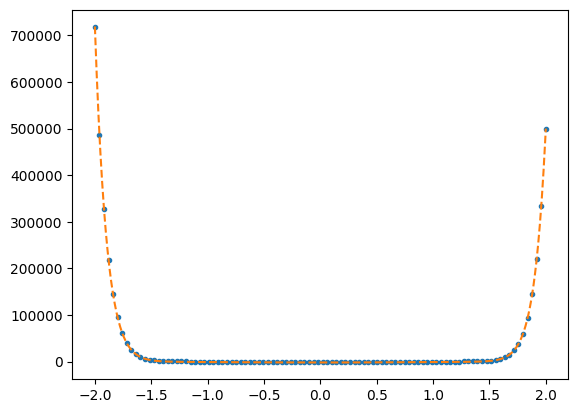

In [2]:
# first generate some data from a random polynomial

k = 20  # order of polynomial
n = 100   # number of data points

x = np.linspace(-2,2,n)
a0 = -1.0 + 2*np.random.rand(k+1)
poly = np.polynomial.Polynomial(a0)
y = poly(x) + np.random.normal(scale=0.0, size=n)
plt.plot(x,y,'.')

# Compute the design matrix
# A_{ij} = f_j(x_i)
A = np.zeros((n, k+1))
for kk in range(k+1):
    A[:, kk] = x**kk

# Now do the linear algebra part 
rhs = np.transpose(A)@y
lhs = np.transpose(A)@A
a = np.linalg.inv(lhs)@rhs

print("Polynomial coeffs, Fitted coeffs, Fractional error")
for i in range(k+1):
    print("%13g %13g %13g" % (a0[i], a[i], (a[i]-a0[i])/a0[i]))

xx = np.linspace(-2,2,1000)
poly = np.polynomial.Polynomial(a)
yy = poly(xx)
plt.plot(xx,yy,'--')

dev = np.sqrt(np.mean((y-poly(x))**2))
print('rms deviation / max(y) = %g' % (dev/np.max(np.abs(y)),))

plt.show()


If you run this with no noise (`scale=0` on line 10), you should see that for low polynomial order the coefficients are fit to machine precision, but the errors become large pretty quickly as you increase the polynomial order. Something is going horribly wrong with the matrix inversion as the polynomial order increases!

## Using Singular Value Decomposition (SVD)

Singular value decomposition (SVD) is extremely useful in these situations where you are dealing with a close-to-singular matrix. The ratio of the largest to smallest singular values is known as the **condition number** of the matrix, and measures how close to singular it is.

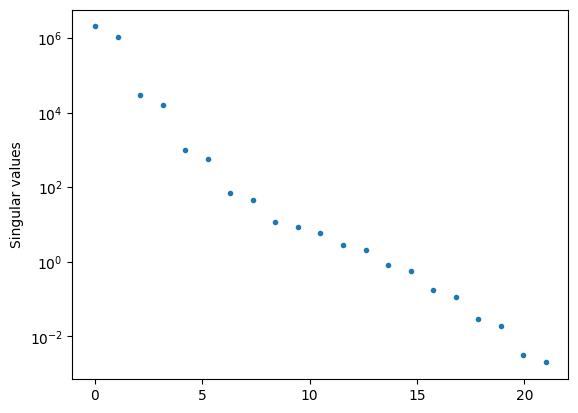

Range of singular values = 1.02088e+09
np.linalg.cond gives 1.02088e+09


In [7]:
U, Sdiag, VT = np.linalg.svd(A,0)

# plot the singular values
plt.clf()
plt.plot(np.linspace(0,len(Sdiag),len(Sdiag)),Sdiag,'.')
plt.yscale('log')
plt.ylabel(r'Singular values')
plt.show()
    
print("Range of singular values = %g" % (max(abs(Sdiag))/min(abs(Sdiag))))

print("np.linalg.cond gives %g" % (np.linalg.cond(A)))

Let's use SVD to rewrite the normal equations:

$$\mathbf{A^T} \mathbf{d} = \mathbf{A^T}\mathbf{A}\mathbf{a}$$ 

$$ \mathbf{VSU^T} \mathbf{d} = \mathbf{VSU^T}\mathbf{USV^T} \mathbf{a}$$ 

$$ \mathbf{VSU^T} \mathbf{d} = \mathbf{VS^2V^T} \mathbf{a}$$ 

$$ \mathbf{V^TVS}\mathbf{U^T} \mathbf{d} = \mathbf{V^T}\mathbf{VS^2V^T} \mathbf{a}$$ 

$$ \mathbf{SU^T} \mathbf{d} = \mathbf{S^2V^T} \mathbf{a}$$ 

$$ \mathbf{U^T} \mathbf{d} = \mathbf{SV^T} \mathbf{a}$$ 

$$\Rightarrow \mathbf{VS^{-1}}\mathbf{U^T} \mathbf{d} =  \mathbf{a}$$ 

The matrix $\mathbf{VS^{-1}}\mathbf{U^T}$ is called the **pseudo-inverse**. We can use it to map from the data vector $\mathbf{d}$ to the model parameters $\mathbf{a}$.


Polynomial coeffs, Fitted coeffs, Fractional error
     0.502193,      0.502193   1.29373e-12
    -0.513689,     -0.513689   1.65206e-10
     0.750319,      0.750319  -2.44553e-11
    -0.347159,     -0.347159  -1.78576e-09
     0.922594,      0.922594  -9.68884e-11
    -0.697536,     -0.697536   8.34525e-09
     -0.46542,      -0.46542   7.78426e-09
    -0.748258,     -0.748258  -8.72636e-09
     0.555326,      0.555326   2.45862e-08
     0.460741,      0.460741  -3.49312e-08
     0.873278,      0.873278  -5.54481e-09
     -0.49199,      -0.49199   -2.3151e-08
    -0.608905,     -0.608905  -5.74922e-09
     -0.27099,      -0.27099   2.02805e-08
      0.14188,       0.14188  -1.11906e-08
    -0.120941,     -0.120941  -4.99209e-09
     0.080548,      0.080548  -3.05745e-10
    -0.509532,     -0.509532   3.66912e-10
     0.590556,      0.590556  -1.06534e-11
   -0.0681404,    -0.0681404  -1.18533e-10
     0.427715,      0.427715   6.44982e-12
rms deviation / max(y) = 9.49446e-12


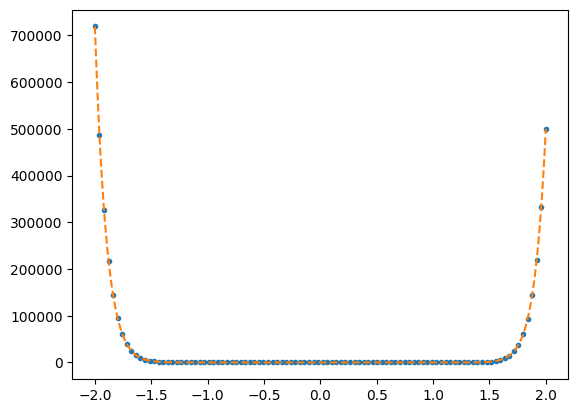

In [4]:
# Find the model parameters using the SVD decomposition
aSVD = VT.T @ np.diag(1/Sdiag) @ U.T @ y

print("Polynomial coeffs, Fitted coeffs, Fractional error")
for i in range(k+1):
    print("%13g, %13g %13g" % (a0[i], aSVD[i], (aSVD[i]-a0[i])/a0[i]))

plt.plot(x,y,'.')

xx = np.linspace(-2,2,1000)
poly = np.polynomial.Polynomial(aSVD)
yy = poly(xx)
plt.plot(xx,yy,'--')

dev = np.sqrt(np.mean((y-poly(x))**2))
print('rms deviation / max(y) = %g' % (dev/np.max(np.abs(y)),))

plt.show()

## Orthogonal polynomials

SVD does a lot better than straight inversion of the normal equations, but still fails for large enough polynomial order. One way that we can do better is to choose a set of basis functions that are orthogonal in the domain that we are interested in. For example, both the Legendre polynomials and the Chebyshev polynomials are orthogonal on the domain $x=(-1,1)$ (which you can rescale to by rescaling your $x$ variable). 

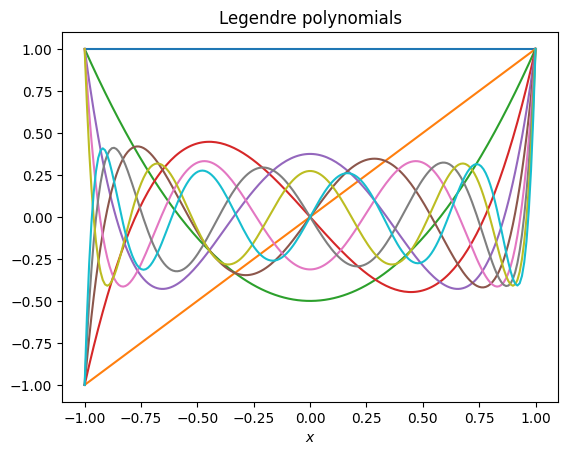

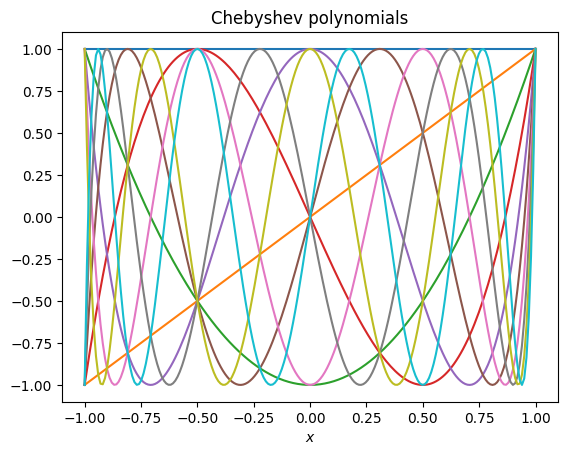

In [5]:
# Plot the Legendre and Chebyshev polynomials

def plot_poly(poly_generator, title):
    for i in range(10):
        x = np.linspace(-1,1,200)
        a = np.zeros(10)
        a[i] = 1
        poly = poly_generator(a)
        plt.plot(x, poly(x))
    plt.xlabel(r'$x$')
    plt.title(title)
    plt.show()


plot_poly(np.polynomial.legendre.Legendre, 'Legendre polynomials')
plot_poly(np.polynomial.chebyshev.Chebyshev, 'Chebyshev polynomials')

> **Exercise**:  Try changing the basis functions to Legendre polynomials or Chebyshev polynomials and see how that improves the fit, both for the inversion and SVD methods.
>
>Things to investigate:
>- How do the results change when you change the number of data points, number of basis functions, and the order of the polynomial that you are fitting?
>- How different is the condition number of the design matrix with these new basis functions compared to what we had before (this will depend on the number of basis functions you use)?
>- Try fitting a more complicated function, e.g. `np.exp(np.sin(x**3)) + np.tanh(x)`
>
>Hint: You can use [`numpy.polynomial.legendre.legvander`](https://numpy.org/devdocs/reference/generated/numpy.polynomial.legendre.legvander.html) and [`numpy.polynomial.chebyshev.chebvander`](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.chebvander.html) to generate the design matrix $\mathbf{A}$ for you.

### Notes and further reading
- If you try fitting a large order polynomial with and without SVD, i.e. a case with very large condition number, you should see that the coefficients returned by SVD are much better behaved. With the straight inversion, successive coefficients often take on large positive and then negative values, to cancel out the contributions from successive basis functions. With SVD on the other hand, these coefficients tend to small values. For more on this, a good place to look is Numerical Recipes, sections 2.6 (on SVD) and 15.4 (for its use in linear least squares). 
- The Chebyshev polynomials have the interesting property that they have maximum or minimum values of $\pm 1$, which makes it easy to assess the errors when approximating functions with a finite number of terms in the Chebyshev expansion. For more on this, look at section 5.8 of Numerical Recipes.